In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats
import numpy as np

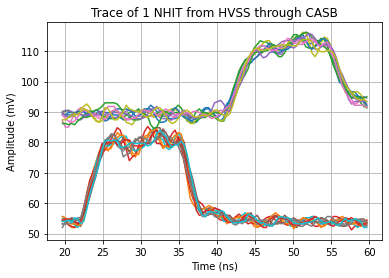

In [19]:
def plot_waveform(df,n):
    try:
        # Plot the data
        plt.plot(df["time"]*1e9, 1e3*(df["output"]), linestyle='-', label=file_path)
        plt.plot(df["time"]*1e9, 1e3*(df["input"]), linestyle='-', label=file_path)
        plt.xlabel("Time (ns)")
        plt.ylabel("Amplitude (mV)")
        plt.title("Trace of 1 NHIT from HVSS through CASB")
        plt.grid(True)
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")

# Loop through files from C1--Trace--0000.txt to C1--Trace--0030.txt
for i in range(10):
    file_path = f'../data/casb2/singles/ch12/tek{i:04d}ALL.csv'  # Format number to 4 digits with leading zeros
    df_casb = pd.read_csv(file_path, skiprows=21, names=["time", "output", "input", "CH3"])
    plot_waveform(df_casb,i)

In [111]:
def getPeakIndex(data,ped,thresh):
    peak=0
    peak_i=0
    thresh_i=0
    start=False
    neg_counter=0
    for i in range(len(data)):
        # start once we cross threshold
        if (data[i]-ped)>thresh and start==False:
            #print(f"Crossed threshold of {thresh} at {data[i]-ped}")
            start=True
            thresh_i=i
        if start==True and data[i]>peak:
            #print(f"Going up! At {data[i]-ped}")
            peak=data[i]
            peak_i=i
        elif start==True and data[i]<=peak:
            #print(f"Going down! At {data[i]-ped}")
            neg_counter+=1
        # Previously crossed threshold and are now regressing
        if start==True and neg_counter>1:
            #print(f"Gone down {neg_counter} times! Stopping")
            break
    #print(f"Found peak at {data[peak_i]-ped}")
    return peak_i,thresh_i

def getPedestal(data,s,e):
    avg=0
    start=int(len(data)*s)
    end=int(len(data)*e)
    for i in range(start,end):
        avg+=data[i]
    return avg/(end-start)

def getLowCrossingTime(time,data,thresh,start_i):
    over=0 # first index where data crosses threshold
    under=0 # index before crossing threshold 
    # Cound down from starting index until we go below thresh
    for i in range(start_i,-1,-1):
        #print(i)
        if data[i]<thresh:
            under=i
            over=i+1
            break
    #print(under,over)
    m=(data[over]-data[under])/(time[over]-time[under])
    cross_time=time[under]+((thresh-data[under])/m)
    #print(time[under]*1e9,round(cross_time*1e9,2),time[over]*1e9)
    return cross_time

def getHighCrossingTime(time,data,thresh,start_i):
    over=0 # first index where data crosses threshold
    under=0 # index before crossing threshold 
    for i in range(start_i,len(data)):
        #print(i)
        if data[i]>thresh:
            over=i
            under=i-1
            break
    #print(under,over)
    m=(data[over]-data[under])/(time[over]-time[under])
    cross_time=time[under]+((thresh-data[under])/m)
    #print(time[under]*1e9,round(cross_time*1e9,2),time[over]*1e9)
    return cross_time

def getRiseTime(time,data,threshLowPC,threshHighPC,thresh,s,e):
    ped=getPedestal(data,s,e)
    peak_i,thresh_i=getPeakIndex(data,ped,thresh)
    amp=data[peak_i]-ped
    # print("-------")
    # print(f"Pedestal {ped*1e3}")
    # print(f"Peak {data[peak_i]*1e3} at {time[peak_i]*1e9}")
    # print(f"Amplitude {amp*1e3}")
    # print(f"Starting at time {time[thresh_i]*1e9}")
    threshLow=ped+amp*threshLowPC/100
    threshHigh=ped+amp*threshHighPC/100
    tLow=getLowCrossingTime(time,data,threshLow,thresh_i)*1e9
    tHigh=getHighCrossingTime(time,data,threshHigh,thresh_i)*1e9
    # print(f"Crossed low of {(threshLow-ped)*1e3} at {tLow}")
    # print(f"Crossed high of {(threshHigh-ped)*1e3} at {tHigh}")
    return tLow,tHigh,amp

def plot_waveform(df,input_tLow,input_tHigh,output_tLow,output_tHigh,input_amp,output_amp):
    try:
        # Plot the data
        fig, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(12, 6))

        inped=getPedestal(df['input'],0.6,1)
        ax1.plot(df["time"]*1e9, (df["input"]-inped), color='blue', label=file_path)
        ax1.axvline(x=input_tLow, color='grey', linestyle='--',label=f'tLow = {input_tLow:.2f} ns')
        ax1.axvline(x=input_tHigh, color='grey', linestyle='--',label=f'tHigh = {input_tHigh:.2f} ns')
        ax1.axhline(y=0, color='grey', linestyle='--')
        ax1.axhline(y=input_amp, color='grey', linestyle='--',label=f'Peak = {input_amp:.2f} mV')
        ax1.set_xlabel("Time (ns)")
        ax1.set_ylabel("Amplitude (V)")
        ax1.set_title(f"HVSS NHIT (rt={round(input_tHigh-input_tLow,3)} ns)")
        ax1.grid()

        outped=getPedestal(df["output"],0,0.5)
        ax2.plot(df["time"]*1e9,(df["output"]-outped), color='red', label=file_path)
        ax2.axvline(x=output_tLow, color='grey', linestyle='--',label=f'tLow = {output_tLow:.2f} ns')
        ax2.axvline(x=output_tHigh, color='grey', linestyle='--',label=f'tHigh = {output_tHigh:.2f} ns')
        ax2.axhline(y=0, color='grey', linestyle='--')   
        ax2.axhline(y=output_amp, color='grey', linestyle='--',label=f'Peak = {output_amp:.2f} mV')
        ax2.set_xlabel("Time (ns)")
        ax2.set_ylabel("Amplitude (V)")
        ax2.set_title(f"CASB analog monitor (rt={round(output_tHigh-output_tLow,3)} ns)")
        ax2.grid()
     
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")



--------------------------------
../data/casb2/singles/ch3/tek0000ALL.csv
--------------------------------
../data/casb2/singles/ch3/tek0001ALL.csv
--------------------------------
../data/casb2/singles/ch3/tek0002ALL.csv
--------------------------------
../data/casb2/singles/ch3/tek0003ALL.csv
--------------------------------
../data/casb2/singles/ch3/tek0004ALL.csv
--------------------------------
../data/casb2/singles/ch3/tek0005ALL.csv
--------------------------------
../data/casb2/singles/ch3/tek0006ALL.csv
--------------------------------
../data/casb2/singles/ch3/tek0007ALL.csv
--------------------------------
../data/casb2/singles/ch3/tek0008ALL.csv
--------------------------------
../data/casb2/singles/ch3/tek0009ALL.csv
--------------------------------
../data/casb2/singles/ch4/tek0000ALL.csv
--------------------------------
../data/casb2/singles/ch4/tek0001ALL.csv
--------------------------------
../data/casb2/singles/ch4/tek0002ALL.csv
--------------------------------
../da

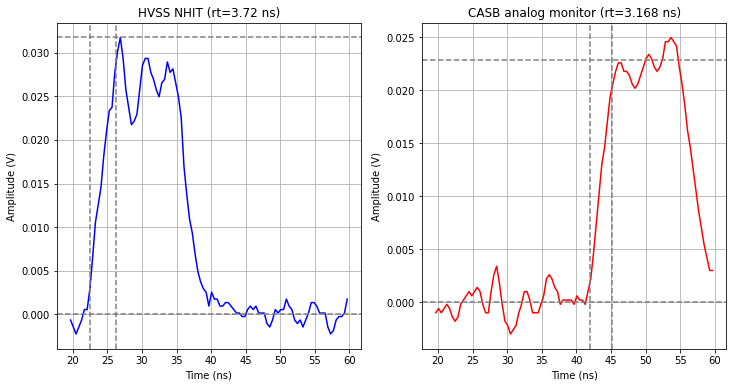

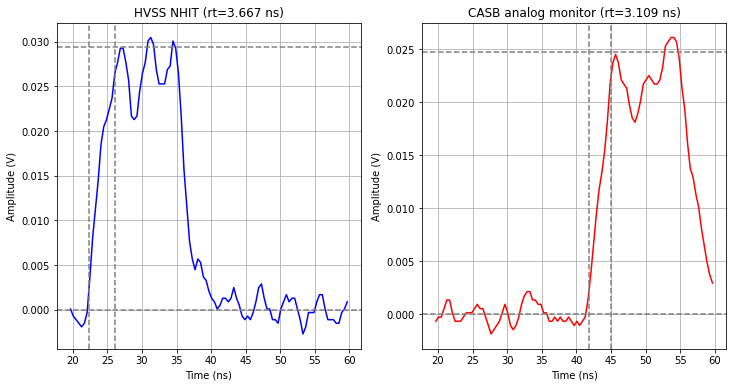

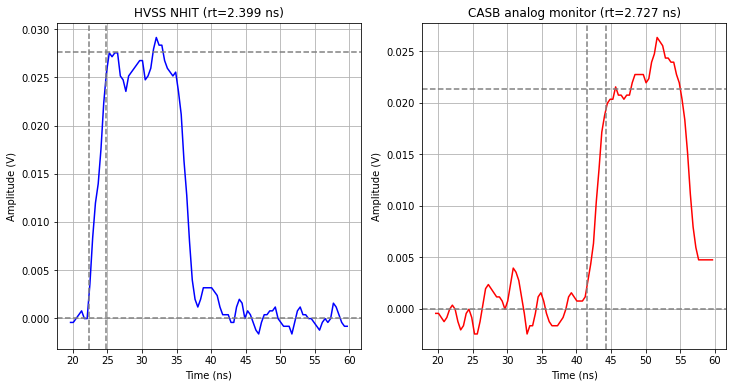

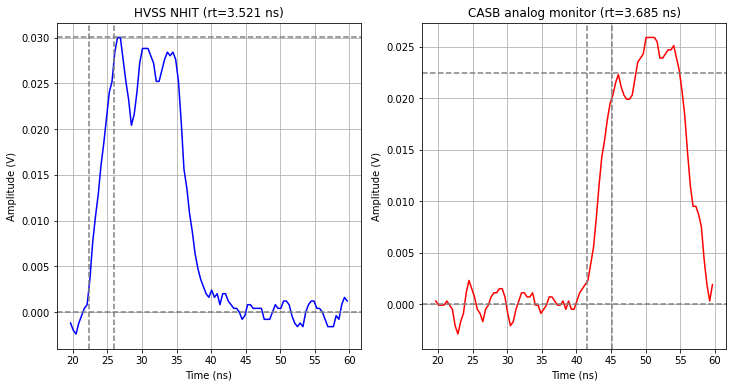

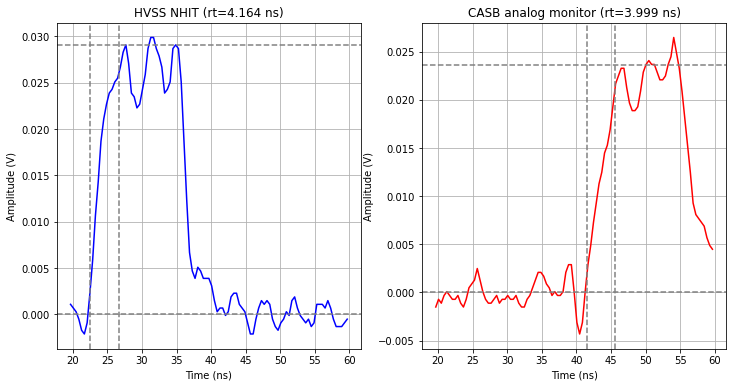

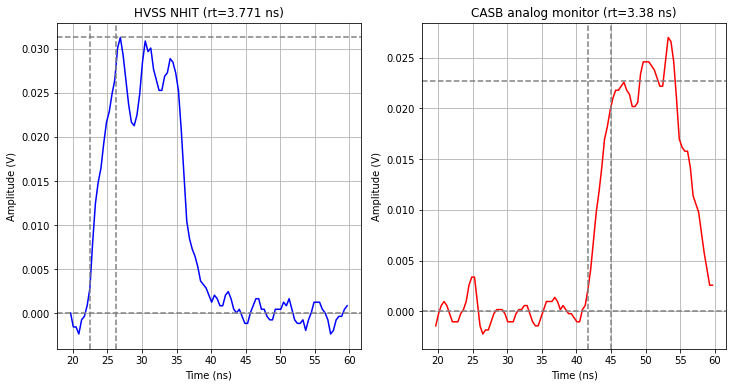

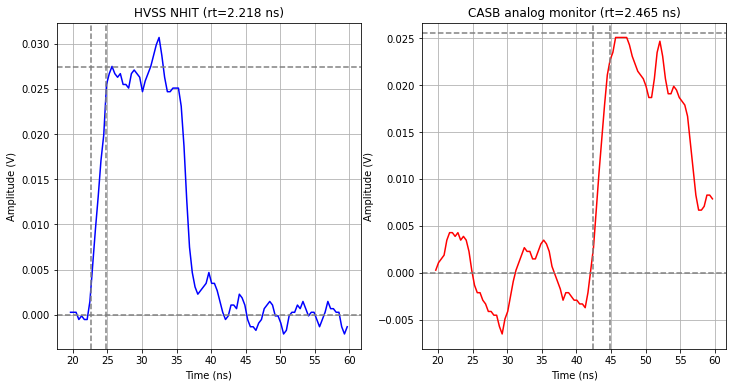

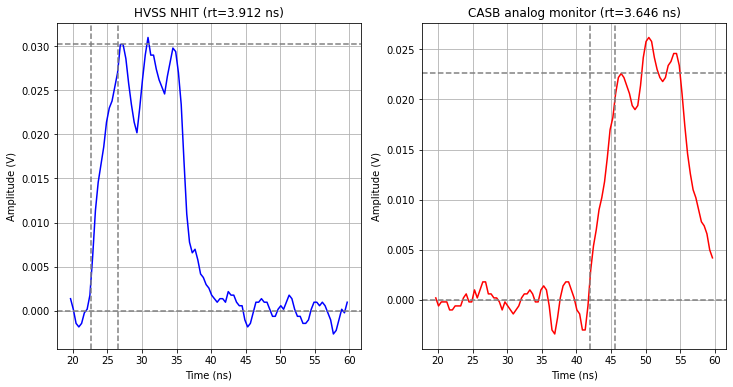

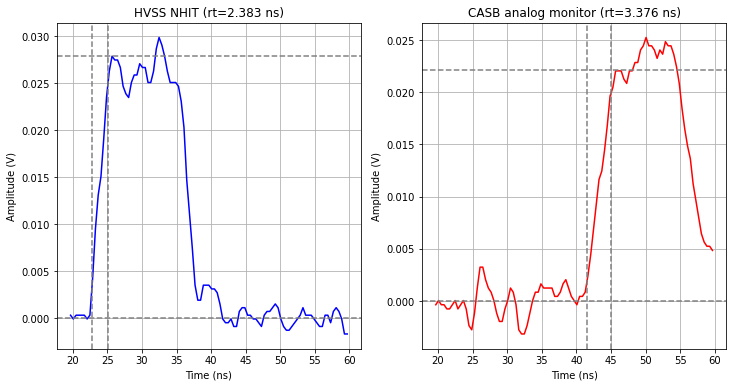

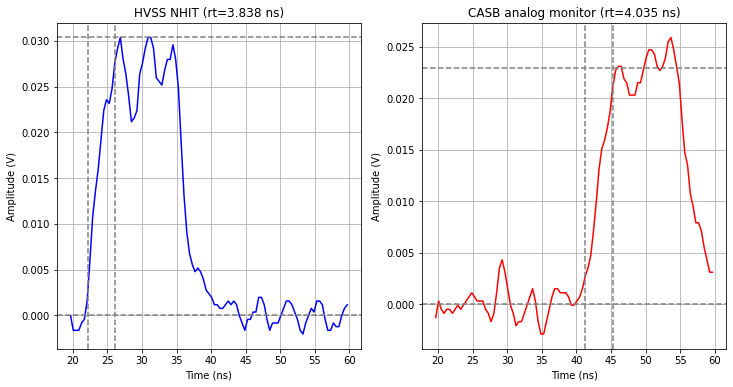

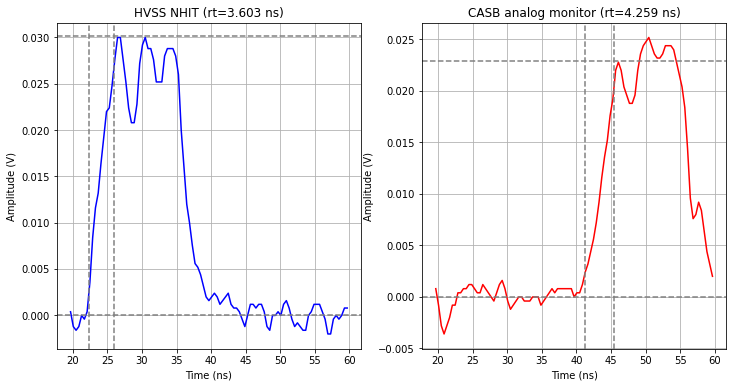

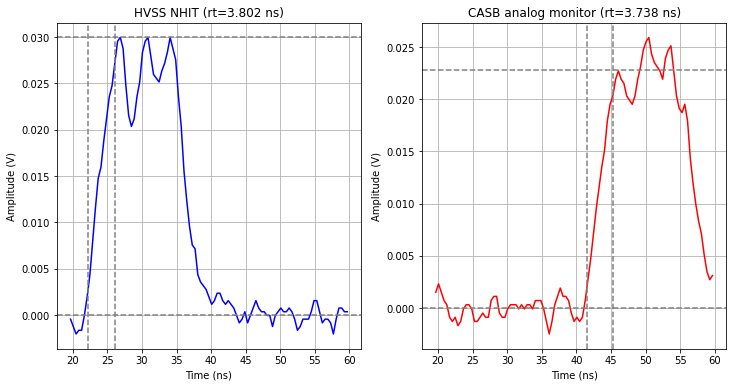

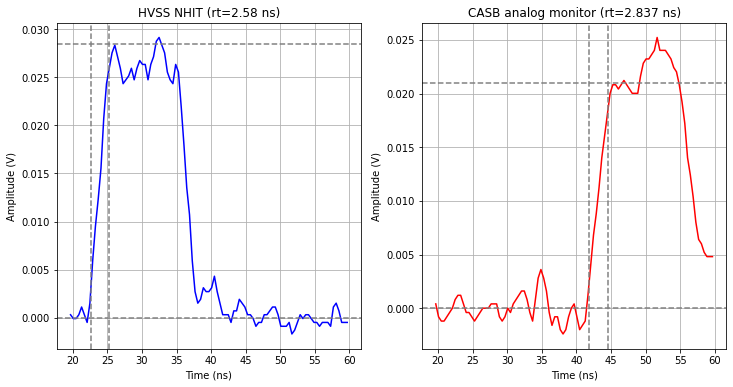

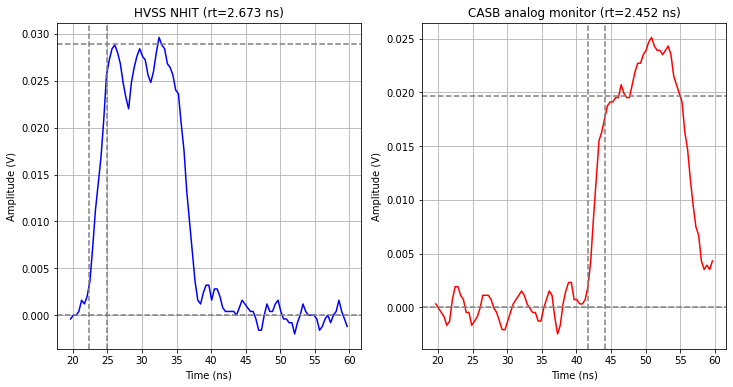

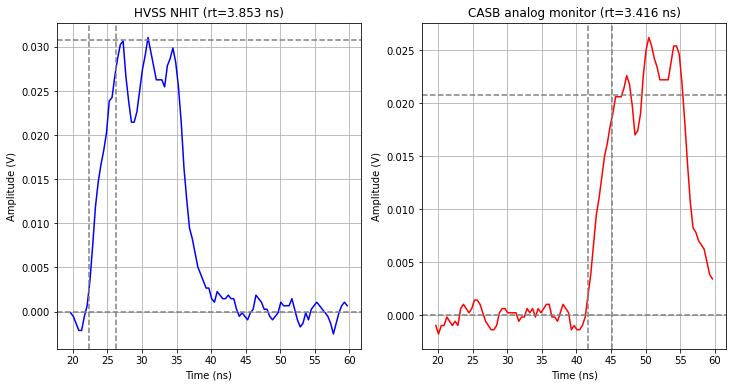

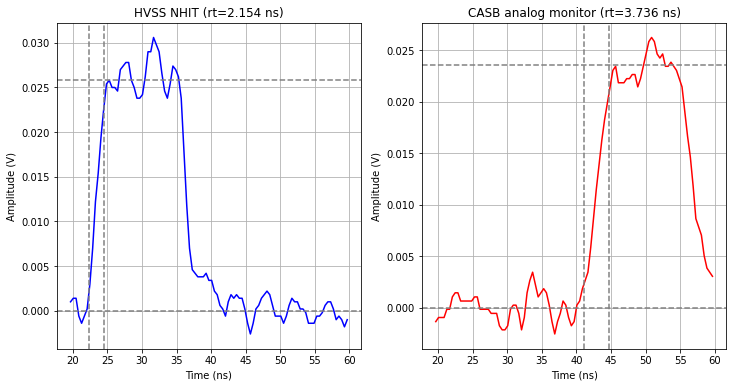

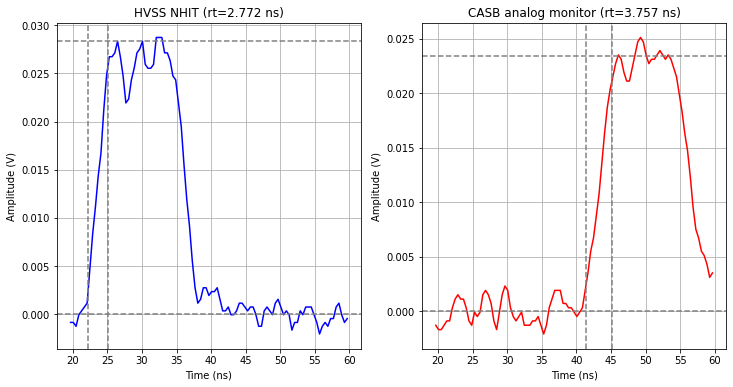

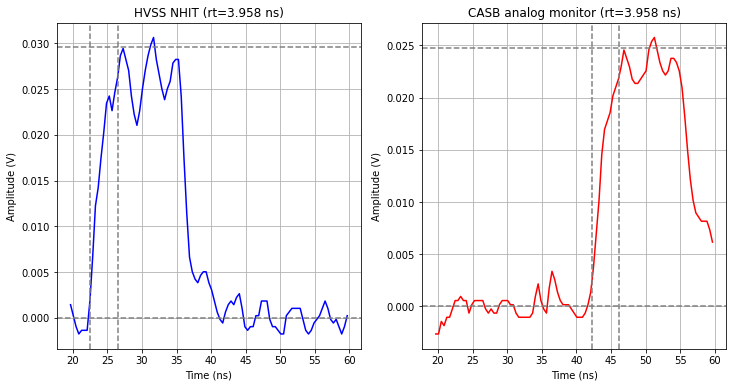

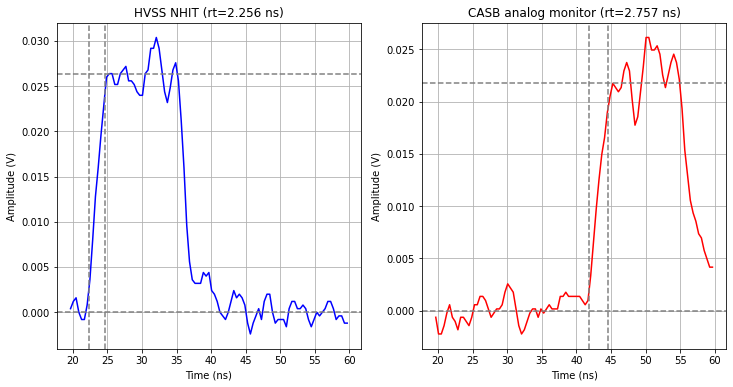

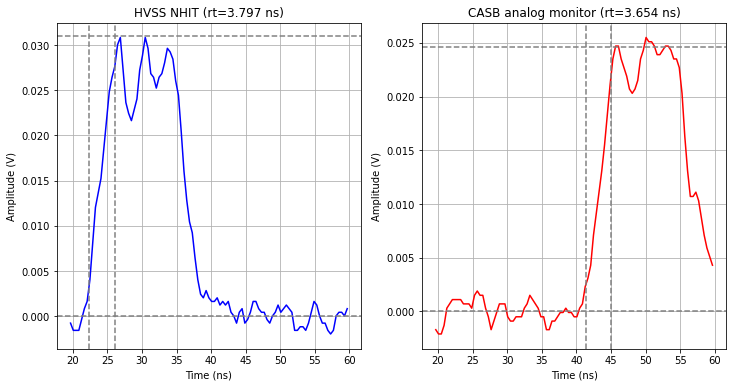

In [112]:

# Loop through files
for i in range(3,5):
    for j in range(0,10):
        file_path = f'../data/casb2/singles/ch{i}/tek{j:04d}ALL.csv'  # Format number to 4 digits with leading zeros
        print("--------------------------------")
        print(file_path)
        df_casb = pd.read_csv(file_path, skiprows=21, names=["time", "output", "input", "CH3"])
        output_tLow,output_tHigh,output_amp=getRiseTime(df_casb["time"],df_casb["output"],10,90,0.01,0,0.3)
        input_tLow,input_tHigh,input_amp=getRiseTime(df_casb["time"],df_casb["input"],10,90,0.01,0.7,1)
        plot_waveform(df_casb,input_tLow,input_tHigh,output_tLow,output_tHigh,input_amp,output_amp)


In [91]:

start,end=10,90

casb1=[]
for i in range(30):
    file_path = f'../data/casb1/singles/C1--Trace--{i:05d}.txt'  # Format number to 4 digits with leading zeros
    df = pd.read_csv(file_path, skiprows=5, names=["Time", "Amplitude"])
    rt=getRiseTime(df['Time'],df['Amplitude'],start,end,0.005)
    print(rt)
    casb1.append(rt)

casb2=[]
for i in range(10):
    file_path= f'../data/casb2/singles/ch1/tek{i:04d}ALL.csv'
    df_casb = pd.read_csv(file_path, skiprows=21, names=["Time", "CH1", "CH2", "CH3"])
    rt=getRiseTime(df_casb["Time"],df_casb["CH1"],start,end,0.005)
    print(rt)
    casb2.append(rt)
    print(file_path)
    file_path= f'../data/singles/ch8/tek{i:04d}ALL.csv'
    df_casb = pd.read_csv(file_path, skiprows=21, names=["Time", "CH1", "CH2", "CH3"])
    rt=getRiseTime(df_casb["Time"],df_casb["CH1"],start,end,0.005)
    print(rt)
    casb2.append(rt)
    print(file_path)
    file_path= f'../data/casb2/singles/ch16/tek{i:04d}ALL.csv'
    df_casb = pd.read_csv(file_path, skiprows=21, names=["Time", "CH1", "CH2", "CH3"])
    rt=getRiseTime(df_casb["Time"],df_casb["CH1"],start,end,0.005)
    print(rt)
    casb2.append(rt)
    print(file_path)
    # file_path= f'ch12/tek{i:04d}ALL.csv'
    # df_casb = pd.read_csv(file_path, skiprows=21, names=["Time", "CH1", "CH2", "CH3"])
    # casb2.append(getRiseTime(df_casb["Time"],df_casb["CH1"],start,end,0.005))
    

mtca=[]    
for i in range(35):
    file_path = f'../data/mtca1/singles/C4--Trace--{i:05d}.txt'  # Format number to 4 digits with leading zeros
    df = pd.read_csv(file_path, skiprows=5, names=["Time", "Amplitude"])
    rt=getRiseTime(df['Time'],df['Amplitude']*-1,start,end,0.02)
    print(rt)
    mtca.append(rt)


TypeError: getRiseTime() missing 2 required positional arguments: 's' and 'e'

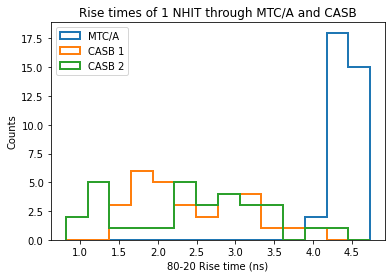

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Determine shared bins
all_data = mtca + casb1 + casb2
bins = np.linspace(min(all_data), max(all_data), 15)

# Plot histograms with shared bins
plt.hist(mtca, bins=bins, density=False, histtype='step', label='MTC/A', linewidth=2)
plt.hist(casb1, bins=bins, density=False, histtype='step', label='CASB 1', linewidth=2)
plt.hist(casb2, bins=bins, density=False, histtype='step', label='CASB 2', linewidth=2)


# Add labels, legend, and title
plt.xlabel(f'{end}-{start} Rise time (ns)')
plt.ylabel('Counts')
plt.title('Rise times of 1 NHIT through MTC/A and CASB')
#plt.yticks(np.arange(0,40,5))
plt.legend()

# Display the plot
plt.show()


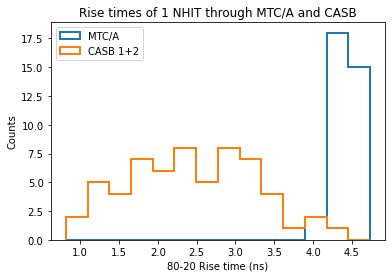

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Determine shared bins
all_data = mtca + casb1 + casb2
bins = np.linspace(min(all_data), max(all_data), 15)

# Plot histograms with shared bins
plt.hist(mtca, bins=bins, density=False, histtype='step', label='MTC/A', linewidth=2)
plt.hist(casb1+casb2, bins=bins, density=False, histtype='step', label='CASB 1+2', linewidth=2)
#plt.hist(casb2, bins=bins, density=False, histtype='step', label='CASB 2', linewidth=2)


# Add labels, legend, and title
plt.xlabel(f'{end}-{start} Rise time (ns)')
plt.ylabel('Counts')
plt.title('Rise times of 1 NHIT through MTC/A and CASB')
#plt.yticks(np.arange(0,40,5))
plt.legend()

# Display the plot
plt.show()
